In [3]:
import pennylane.numpy as np 
import matplotlib.pyplot as plt 
import pennylane as qml 
#from VarQFT import QFT, classical_swaps

In [4]:
def empty_state():
    pass

class VarFourier:

    def __init__( self, 
                    num_qubits, 
                    fun_x, 
                    fun_p,
                    dev,
                    var_state = None, 
                    state_in  = None, 
                    semi_classical = False,
                    xmin = -1, 
                    xmax = 1 ):

        if var_state is None:
            self.var_state = empty_state
        else:
            self.var_state = var_state

        if state_in is None:
            self.state_in = empty_state
        else:
            self.state_in = state_in

        self.num_qubits = num_qubits
        self.fun_x = fun_x
        self.fun_p = fun_p
        self.dev   = dev
        self.semi_classical = semi_classical
        self.xmin  = xmin
        self.xmax  = xmax

        x_values, p_values = self.grid_op()
        self.x_values = x_values
        self.p_values = p_values

        self.fun_x_values = fun_x(x_values)
        self.fun_p_values = fun_p(p_values)

    def Fourier( self, dim ):
        F = np.exp( -2j*np.pi*np.outer(np.arange(dim),
                                        np.arange(dim))/dim 
                                        ) / np.sqrt(dim) 
        return F 

    def grid_op(self):

        dim = 2 ** self.num_qubits 
        L   = self.xmax - self.xmin
        dx  = L / (2**self.num_qubits - 1)
        k  = np.linspace( -np.pi / dx, 
                            np.pi / dx, 
                            dim + 1)[:-1]
        
        x_values = self.xmin + dx * np.arange(dim)
        p_values = np.fft.fftshift(k)

        return x_values, p_values
    
    def matrix_op( self ):

        x_values, p_values = self.grid_op()

        dim = 2 ** self.num_qubits 
        F = self.Fourier(dim)

        Op = np.diag( self.fun_x(x_values) ) \
            + F.T.conj()@np.diag( self.fun_p(p_values) )@F
        
        return Op

    def X_eval(self):
        
        @qml.qnode(self.dev)
        def circuit_x(params):
            self.state_in()
            self.var_state(params)
            return MyMP( wires=list(range(self.num_qubits)), eigvals=self.fun_x_values  )
        
        return circuit_x
    
    def P_eval(self):

        @qml.qnode(self.dev)
        def circuit_p(params):
            self.state_in()
            self.var_state(params)
            QFT( self.num_qubits, self.semi_classical )
            return MyMP( wires=list(range(self.num_qubits)), eigvals=self.fun_p_values )
        
        return circuit_p


    def energy_eval( self, 
                    params ):
        
        circuit_x = self.X_eval()
        circuit_p = self.P_eval()

        ExpVal = circuit_x(params) + circuit_p(params)
        
        return ExpVal

(<Figure size 800x300 with 1 Axes>, <Axes: >)

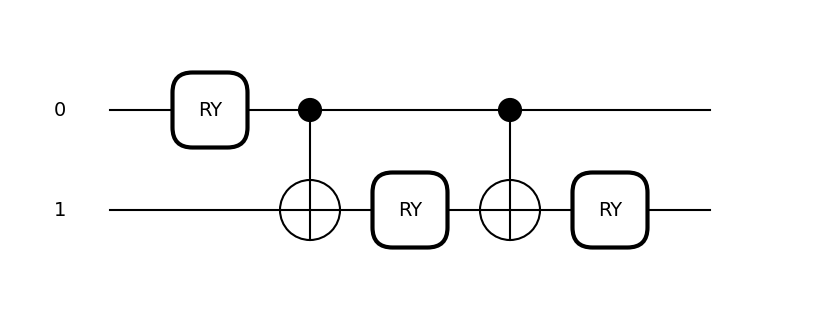

In [5]:
num_qubits = 2
ansatz = "ry ansatzw"
if ansatz == "ry ansatz":
    def var_state(params):
        for layer, params_per_layer in enumerate(params):
            for wire in range(num_qubits):
                qml.Rot(*params_per_layer[wire], wires=wire)

            if layer < len(params)-1:
                for wire in range(num_qubits-1):
                    qml.CNOT([wire,wire+1])

    num_layers = 4
    params_init = 0.01 * np.random.randn( num_layers, num_qubits, 3, requires_grad=True)


else: # Use ZGR ansatz instead

    def var_state(params):
        # num_params = sum_{i=0}^{num_qubits} 2^{i} 
        #            = 2^{num_qubits+1} - 1
        #qml.QubitStateVector(gaussian_GS(Xs)/np.linalg.norm(gaussian_GS(Xs)),wires=[0,1,2])
        for layer, params_per_layer in enumerate(params):
            qml.RY(params_per_layer[0], wires=0)
            i = 1
            for qubit in range(num_qubits):
                for _ in range(2):
                    for ctrl in range(qubit):
                        qml.CNOT(wires=[ctrl, qubit])
                        qml.RY(params_per_layer[qubit], wires=qubit)
                        i += 1
                        
        #return circuit
    '''
    def var_state(params):
    # num_params = sum_{i=0}^{num_qubits} 2^{i} 
    #            = 2^{num_qubits+1} - 1
    for layer, params_per_layer in enumerate(params):
        qml.Rot(*params_per_layer[0], wires=0)
        i = 1
        for qubit in range(num_qubits):
            for _ in range(2):
                for ctrl in range(qubit):
                    qml.CNOT(wires=[ctrl, qubit])
                    qml.Rot(*params_per_layer[qubit], wires=qubit)
                    i += 1
                        
        #return circuit
    '''
    num_layers = 1
    params_init = 0.01 * np.random.randn( num_layers, 2**(num_qubits) - 1, requires_grad=True)
    #var_state = zgr_ansatz(num_qubits)

qml.draw_mpl(var_state)(params_init)

In [100]:
num_qubits = 3
def state_in():
    #qml.QubitStateVector(gaussian_GS(Xs)/np.linalg.norm(gaussian_GS(Xs)),wires=[0,1,2])
    qml.Identity(wires=0)
dev = qml.device( "lightning.qubit", 
                    wires=num_qubits)
                    #shots = 10000)

In [101]:
varfourier = VarFourier( num_qubits, 
                        lambda x : x**2/2, 
                        lambda p : p**2/2,
                        dev,
                        var_state,
                        state_in=state_in, 
                        semi_classical=False,
                        xmin = -5,
                        xmax = +5  )

In [102]:
Xs, Ps = varfourier.grid_op()

fourier = varfourier.Fourier(dim=2**num_qubits)

In [103]:
operator = varfourier.matrix_op()

In [104]:
vals, vecs = np.linalg.eigh(operator)

In [105]:
vals[0]

0.5175191349133402

In [106]:
psi  = np.exp(-(Xs**2) / 2)
psi_norm = psi/np.linalg.norm(psi)

In [107]:
vecs[:,0]

tensor([-2.26128597e-04+0.00000000e+00j, -1.34434618e-04-7.16777267e-18j,
        -1.01296521e-01-3.35970018e-15j, -6.99813508e-01-2.30077753e-14j,
        -6.99813508e-01-2.30680730e-14j, -1.01296521e-01-3.29531571e-15j,
        -1.34434618e-04-3.61812052e-18j, -2.26128597e-04-6.32348893e-18j], requires_grad=True)

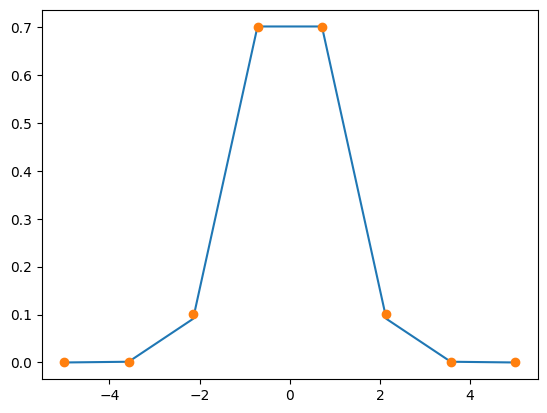

In [108]:
plt.plot(Xs,np.abs(psi_norm))
plt.plot(Xs,np.abs(vecs[:,0]),'o')


(<Figure size 400x400 with 1 Axes>, <Axes: >)

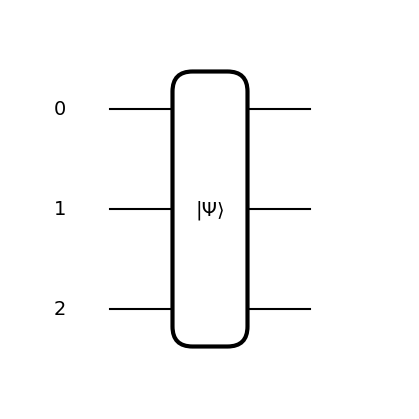

In [109]:
def circuit(params):
    qml.AmplitudeEmbedding(params, normalize=True, wires=range(num_qubits))



qml.draw_mpl(circuit)(vecs[:, 0])


In [200]:
def QFT(n_wires, semi_classical=False):

    if semi_classical:
        mid_measures = []
        for n in range( n_wires ):
            qml.Hadamard( wires=n )
            if n < n_wires-1:
                mid_measure = qml.measure( wires=n ) 
                mid_measures.append( mid_measure )
                for m in range(1,n_wires-n):
                    qml.cond( mid_measure, 
                                qml.ControlledPhaseShift )( np.pi/2**m, 
                                            wires=n+m ) 

    else:
        '''
        for n in range( n_wires ):
            qml.Hadamard(wires=num_qubits-n-1)
            for m in range(1,n_wires-n):
                qml.ControlledPhaseShift( np.pi/2**m, wires=[num_qubits-n-1-m,num_qubits-n-1]  )
        '''
        for n in range( n_wires ):
            qml.Hadamard(wires=n)
            for m in range(1,n_wires-n):
                qml.ControlledPhaseShift( np.pi/2**m, wires=[n,n+m]  )


def classical_swaps( probs, n_wires ):
    return probs.reshape(n_wires*[2]).transpose(np.arange(n_wires)[::-1]).reshape(2**n_wires)

In [201]:
np.pi/4

0.7853981633974483

(<Figure size 1100x400 with 1 Axes>, <Axes: >)

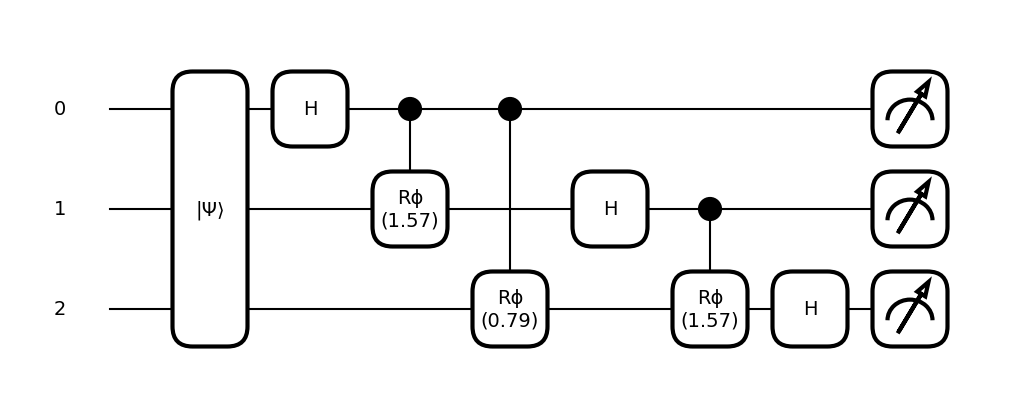

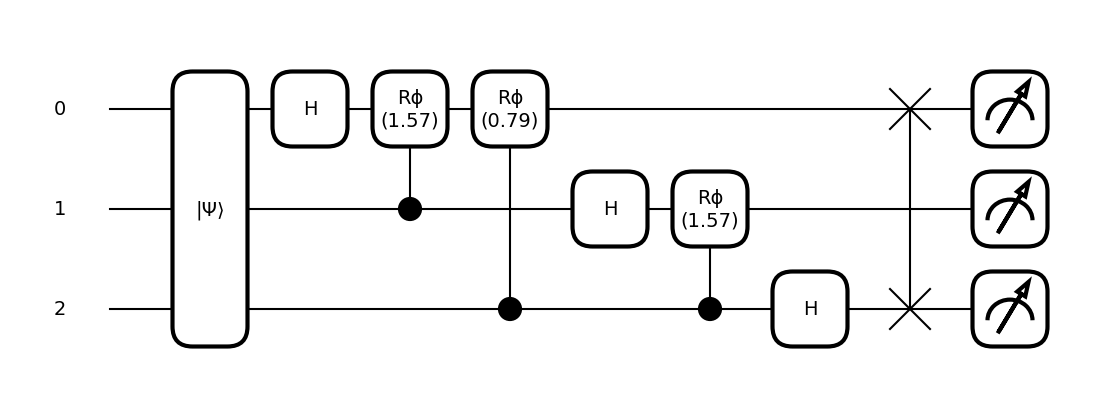

In [202]:
@qml.qnode(dev)
def circuit_X(params):
    qml.AmplitudeEmbedding(params, normalize=True, wires=range(num_qubits))
    #QFT(num_qubits)
    return qml.probs()

@qml.qnode(dev)
def circuit_P(params):
    qml.AmplitudeEmbedding(params, normalize=True, wires=range(num_qubits))
    QFT(num_qubits)
    #qml.QFT(wires = range(num_qubits))
    #qml.QFT.compute_decomposition(wires = range(num_qubits), n_wires=num_qubits)
    return qml.probs()

@qml.qnode(dev)
def circuit_P_qml(params):
    qml.AmplitudeEmbedding(params, normalize=True, wires=range(num_qubits))
    #QFT(num_qubits)
    #qml.QFT(wires = range(num_qubits))
    qml.QFT.compute_decomposition(wires = range(num_qubits), n_wires=num_qubits)
    #qml.SWAP([0,2])
    return qml.probs()

qml.draw_mpl(circuit_P, decimals=2 )(vecs[:, 0])
qml.draw_mpl(circuit_P_qml, decimals=2 )(vecs[:, 0])



In [203]:
qml.QFT.compute_decomposition(wires = range(num_qubits), n_wires=num_qubits)


[Hadamard(wires=[0]),
 ControlledPhaseShift(1.5707963267948966, wires=[1, 0]),
 ControlledPhaseShift(0.7853981633974483, wires=[2, 0]),
 Hadamard(wires=[1]),
 ControlledPhaseShift(1.5707963267948966, wires=[2, 1]),
 Hadamard(wires=[2]),
 SWAP(wires=[0, 2])]

In [204]:
Ps**2

tensor([0.        , 0.30225663, 1.20902654, 2.72030971, 4.83610616,
        2.72030971, 1.20902654, 0.30225663], requires_grad=True)

In [209]:
probsx = circuit_X(vecs[:,0])
probsp_qml = circuit_P_qml(vecs[:,0])
probsp =  classical_swaps(circuit_P(vecs[:,0]),num_qubits)

In [210]:
Xs

tensor([-5.        , -3.57142857, -2.14285714, -0.71428571,  0.71428571,
         2.14285714,  3.57142857,  5.        ], requires_grad=True)

In [211]:
probsp

array([3.21177555e-01, 2.34645049e-01, 8.95830883e-02, 1.51830854e-02,
       2.97702547e-29, 1.51830854e-02, 8.95830883e-02, 2.34645049e-01])

In [212]:
probsp_qml

array([3.21177555e-01, 2.34645049e-01, 8.95830883e-02, 1.51830854e-02,
       2.97702547e-29, 1.51830854e-02, 8.95830883e-02, 2.34645049e-01])

In [199]:
(np.vdot(probsx,Xs**2)+np.vdot(probsp,Ps**2))/2

0.9145571077474718